In [6]:
COUNTRY_CODE = "DE"
import dask.dataframe as dd
import pytz
import numpy as np
import pandas as pd


In [2]:
def transform_freq_data(freq):
    interval_index = freq.index[::3600]
    Y = freq.values.astype('float64').reshape((freq.shape[0]//3600, 3600))
    Y = pd.DataFrame(data=Y[:,:3600], index = interval_index, columns=np.arange(3600))
    return Y

# Use Dask to read large CSV files
freq_2015 = dd.read_csv(f"/home/qnlzgl/sequence-model-and-gaussian-process-for-frequency-prediction-main/data_{COUNTRY_CODE}/{COUNTRY_CODE}/2015.csv", header=None, names=['timestamp', 'freq'])
freq_2016 = dd.read_csv(f"/home/qnlzgl/sequence-model-and-gaussian-process-for-frequency-prediction-main/data_{COUNTRY_CODE}/{COUNTRY_CODE}/2016.csv", header=None, names=['timestamp', 'freq'])
freq_2017 = dd.read_csv(f"/home/qnlzgl/sequence-model-and-gaussian-process-for-frequency-prediction-main/data_{COUNTRY_CODE}/{COUNTRY_CODE}/2017.csv", header=None, names=['timestamp', 'freq'])
freq_2018 = dd.read_csv(f"/home/qnlzgl/sequence-model-and-gaussian-process-for-frequency-prediction-main/data_{COUNTRY_CODE}/{COUNTRY_CODE}/2018.csv", header=None, names=['timestamp', 'freq'])
freq_2019 = dd.read_csv(f"/home/qnlzgl/sequence-model-and-gaussian-process-for-frequency-prediction-main/data_{COUNTRY_CODE}/{COUNTRY_CODE}/2019.csv", header=None, names=['timestamp', 'freq'])

# Concatenate the Dask DataFrames
freq = dd.concat([freq_2015, freq_2016, freq_2017, freq_2018, freq_2019])

# Set timezone and process timestamps
tz = pytz.timezone('GB' if COUNTRY_CODE == "GB" else 'Europe/Berlin')

# Dask doesn't have direct support for time zone localization; you need to compute the index in-memory.
# First, convert the index to datetime and then localize and convert the timezone.
freq['timestamp'] = dd.to_datetime(freq['timestamp'])
freq = freq.set_index('timestamp')

# Perform operations on smaller chunks
def process_timestamps(df):
    df.index = df.index.tz_localize(tz, ambiguous='NaT').tz_convert('UTC').tz_localize(None)
    return df

# Use `map_partitions` to apply the function to each partition
freq = freq.map_partitions(process_timestamps)

# Write train and test sets to pickle format, converting Dask DataFrame to Pandas for the final output
freq_train = freq.loc[:"2018"].compute()
transform_freq_data(freq_train).to_pickle(f"../data_{COUNTRY_CODE}/frequency_train.pkl")
freq_test = freq.loc["2019":].compute()
transform_freq_data(freq_test).to_pickle(f"../data_{COUNTRY_CODE}/frequency_test.pkl")

In [4]:
output_DE = pd.read_hdf(f'../data_{COUNTRY_CODE}/{COUNTRY_CODE}/outputs.h5')


In [8]:
features = pd.read_hdf(f'../data_{COUNTRY_CODE}/{COUNTRY_CODE}/input_forecast.h5')
features

In [3]:
features = pd.read_hdf(f'../data_{COUNTRY_CODE}/{COUNTRY_CODE}/input_forecast.h5')
features.loc[:,'hour_sin'] = np.sin((features.index.hour + features.index.minute/60)/24*2*np.pi)
features.loc[:,'hour_cos'] = np.cos((features.index.hour + features.index.minute/60)/24*2*np.pi)
features = features.reset_index().rename(columns={'index': 'timestamp'})
features['timestamp'] = features['timestamp'].dt.tz_localize(None)
# Merge features with freq (assuming freq is already processed as in the previous example)
df = dd.merge(left=features, right=freq, left_on='timestamp', right_index=True, how='left')

# Rename and select specific columns
df = df.rename(columns={'freq': 'initial_frequency_value'})[[
    'solar_day_ahead', 
    'wind_on_day_ahead', 
    'wind_off_day_ahead', 
    'prices_day_ahead', 
    'load_day_ahead', 
    'load_ramp_day_ahead', 
    'total_gen_ramp_day_ahead', 
    'wind_off_ramp_day_ahead', 
    'wind_on_ramp_day_ahead', 
    'solar_ramp_day_ahead', 
    'price_ramp_day_ahead', 
    'hour_sin', 
    'hour_cos', 
    'initial_frequency_value'
]]


# Save to pickle files by computing Dask DataFrame and converting to Pandas DataFrame
df.loc[:"2018"].compute().to_pickle(f"../data_{COUNTRY_CODE}/day_ahead_features_train.pkl")
df.loc["2019":].compute().to_pickle(f"../data_{COUNTRY_CODE}/day_ahead_features_test.pkl")

NameError: name 'pd' is not defined

In [2]:
import pandas as pd
freq_2019 = pd.read_csv("/home/qnlzgl/sequence-model-and-gaussian-process-for-frequency-prediction-main/data_GB/GB/2019.csv", header=None, names=['timestamp', 'freq'])
freq_2019['timestamp'] = pd.to_datetime(freq_2019['timestamp'])
freq_2019 = freq_2019.set_index('timestamp')
freq_2019 = freq_2019[::60]

/tmp/ipykernel_17924/3006213573.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq_2019['freq'].resample('H').mean().dropna()


timestamp
2019-01-01 00:00:00    50.008983
2019-01-01 01:00:00    50.035633
2019-01-01 02:00:00    50.016967
2019-01-01 03:00:00    49.952600
2019-01-01 04:00:00    49.970533
                         ...    
2019-12-31 19:00:00    50.039083
2019-12-31 20:00:00    49.969450
2019-12-31 21:00:00    50.051067
2019-12-31 22:00:00    50.003883
2019-12-31 23:00:00    49.959450
Name: freq, Length: 8759, dtype: float64

In [37]:
freq_2019['freq'][::60]

timestamp
2019-01-01 00:00:00    50.107
2019-01-01 01:00:00    50.075
2019-01-01 02:00:00    49.975
2019-01-01 03:00:00    49.970
2019-01-01 04:00:00    49.967
                        ...  
2019-12-31 19:01:00    50.100
2019-12-31 20:01:00    49.933
2019-12-31 21:01:00    49.911
2019-12-31 22:01:00    50.000
2019-12-31 23:01:00    49.902
Name: freq, Length: 8760, dtype: float64

/tmp/ipykernel_17924/1839736849.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  acf_values = acf(freq_2019['freq'].resample('H').mean().dropna(), nlags=50, fft=True)


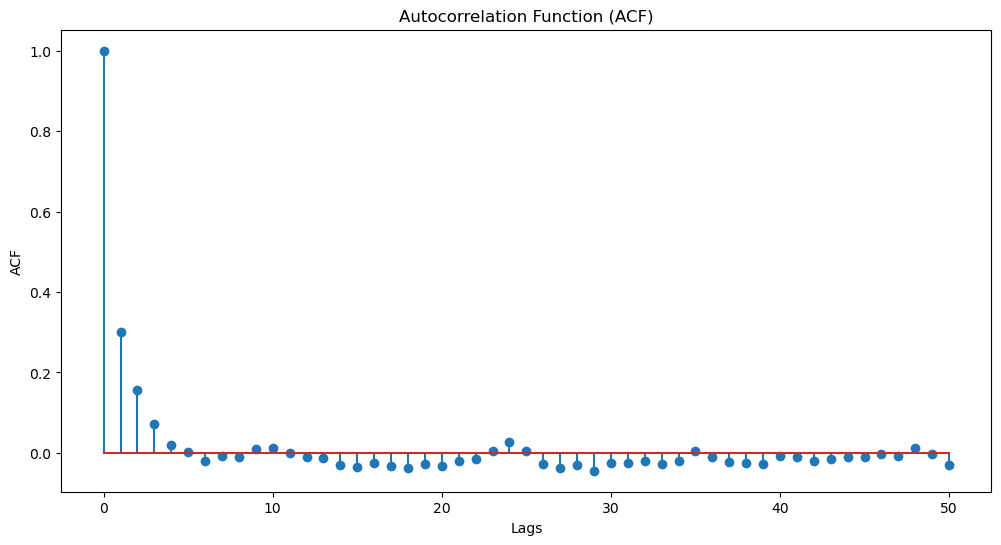

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf


# Calculate ACF
freq_2019.dropna(subset=['freq'], inplace=True)
acf_values = acf(freq_2019['freq'].resample('H').mean().dropna(), nlags=50, fft=True)
acf_values

# Plot ACF
plt.figure(figsize=(12, 6))
plt.stem(range(len(acf_values)), acf_values)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

# # Plot PACF
# plt.figure(figsize=(12, 6))
# plot_pacf(freq_2019['freq'], lags=50, ax=plt.gca())
# plt.title('Partial Autocorrelation Function (PACF)')
# plt.show()


/tmp/ipykernel_17924/3231632787.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plot_pacf(freq_2019['freq'].resample('H').mean().dropna(), lags=50, alpha=0.05, zero=False, ax=ax)


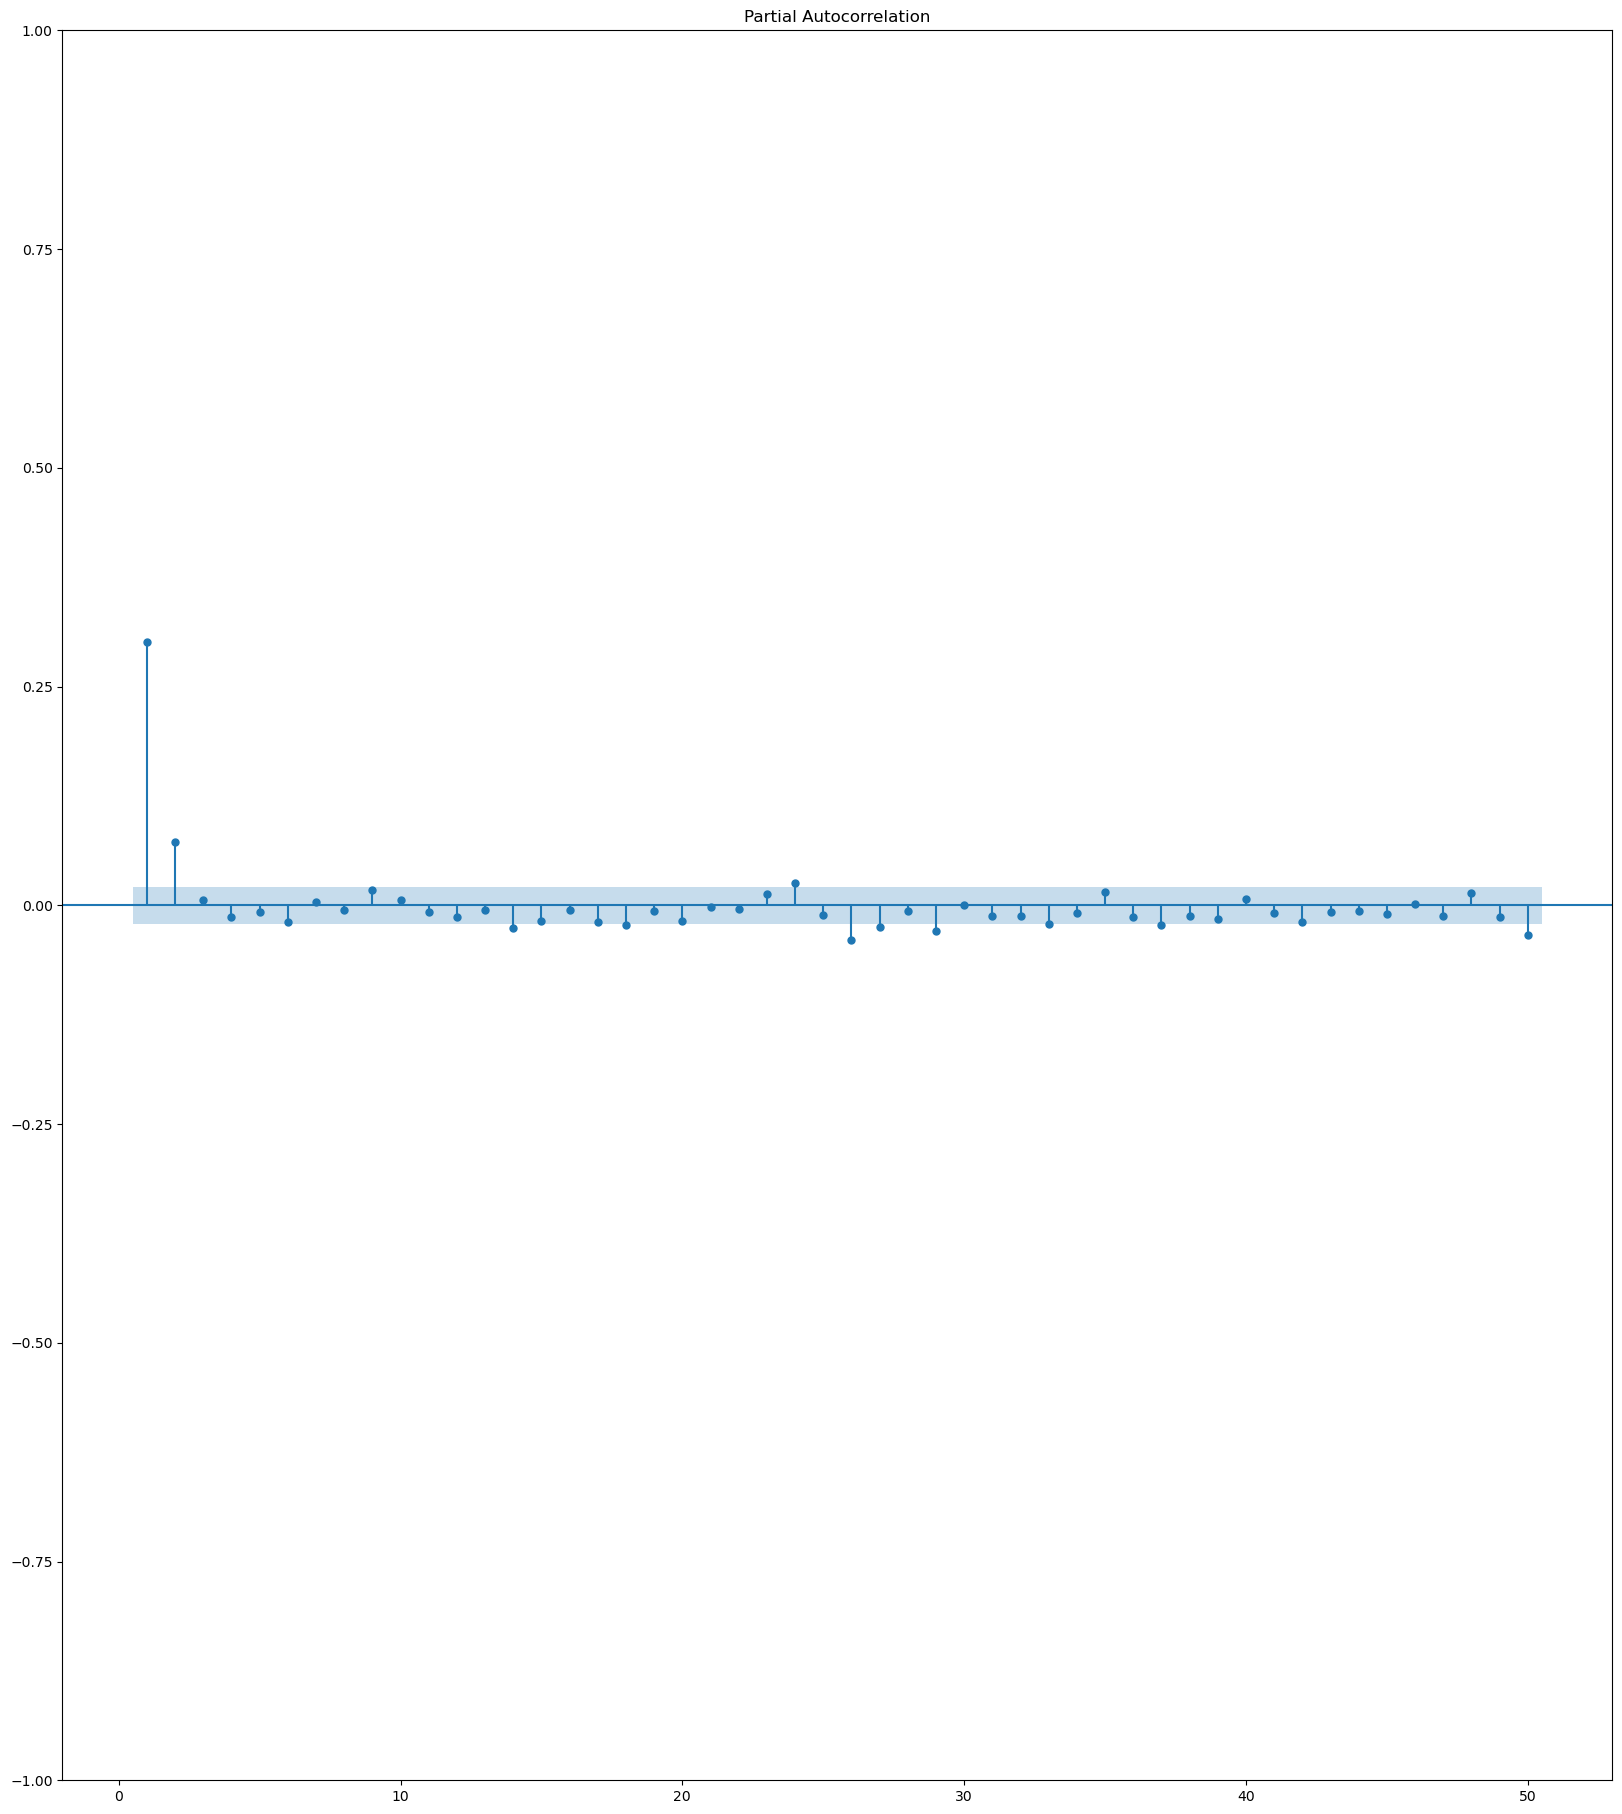

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot PACF
plt.figure(figsize=(20, 50))

ax = plt.subplot(211)
plot_pacf(freq_2019['freq'].resample('H').mean().dropna(), lags=50, alpha=0.05, zero=False, ax=ax)
plt.show()
